# Mutual Information Estimation Example

This repository implements some models and test-cases to estimate the mutual information and conditional mutual information, based on a set of samples from the joint distribution of the associated random variables (e.g. timepoints from some time-series data). The general idea, as discussed below, was around for quite some time, but the idea of actually using it in this way, and experiments comparing this approach with other approaches to estimate the (conditional) mutual information between high-dimensional random variables, were (to the best of my knowledge, please correct me if I missed some important work) first published by Mukherjee et al. (2019; https://arxiv.org/abs/1906.01824) and Ghimire et al. (2020, https://arxiv.org/abs/2002.11187).

The following deep-learning and sampling based approach to calculate the mutual information between samples of two high-dimensional variables rests on the following idea: the mutual information $MI(X,Y)$ of two variables $x$, $y$ is the Kullback-Leibler divergence between their joint probability density $p(x,y)$ and the product of their marginals $p(x)p(y)$:

$$MI(X,Y) = D_{KL}(p(x,y)||p(x)p(y))$$

The Kullback-Leibler divergence of two densities $p$, $q$ is defined as

$$D_{KL}(p(x)||q(x)) = \int p(x) \log \left(\frac{p(x)}{q(x)}\right)\mathrm{d}x$$

It is zero if, and only if, $p(x) = q(x)$ for all $x$.

Recent articles about the discriminator based learning of probability densities (https://arxiv.org/abs/1406.2661, https://arxiv.org/abs/1610.03483, https://arxiv.org/abs/1702.08235, https://arxiv.org/abs/1701.04722, https://arxiv.org/abs/1702.08896) realized and built upon a really cool fact: 

We can train a deep neural network, $D$, to discriminate between samples $x_i$ from two distributions, $p(x)$ and $q(x)$, using the cross-entropy loss

$$ BCE(\{x_i, y_i\}) = - \sum_{i=1}^n y_i\log(\sigma(D(x_i))) + (1 - y_i)log(1-\sigma(D(x_i)))$$

where the labels $y_i = y(x_i) = 1$ if $x_i$ was drawn from $p(x)$, and $y_i = y(x_i) = 0$ if $x_i$ was drawn from $q(x)$.

If the training of this network converges, and if the network has enough capacity (in terms of numbers of layers and hidden units), $D(x)$ will converge to the log-likelihood ratio $D(x)\approx \log\frac{p(x)}{q(x)}$.

Thus, if the network training converged, we can use a large number of samples $x_i$ from $p(x)$ to calculate

$$\frac{1}{n}\sum_{i=1}^n D(x_i) \approx \int p(x) \log\frac{p(x)}{q(x)} \mathrm{d}x = D_{KL}(p(x)||q(x))$$.

To really understand this fact, which I'm just stating here, I can heartly recommend the paper Mescheder, Nowozin and Geiger (https://arxiv.org/abs/1701.04722), who nicely explain the underlying maths and give the relevant proofs. But please keep in mind that this and similar ideas were unsurprisingly also developed and discussed in many other great papers; e.g. https://arxiv.org/abs/1406.2661, https://arxiv.org/abs/1610.03483, https://arxiv.org/abs/1702.08235, https://arxiv.org/abs/1702.08896.

To use this fact to calculate the mutual information between samples from two high-dimensional random variables, $x$ and $y$, we implement a special case of this approach, where the discriminator learns to discriminate between samples from the joint distribution $p(x,y)$ and samples from the product of the marginal distributions $p(x)p(y)$. By evaluating and averaging the trained classifier, using samples from $p(x,y)$, we can approximates the KL-divergence between $p(x,y)$ and $p(x)p(y)$, $D_{KL}(p(x,y)||p(x)p(y))$, which is just the mutual information MI(X,Y) between the variables $x$ and $y$.

Further down, we built on this to implement a sampling based approximation of the conditional mutual information $CMI(X,Y|Z)$ of three random variables $x$, $y$, and $z$.

But let us first check out, how the estimation of the mutual information between two variables $x$ and $y$ works in practice using this approach. 

All we need for this is a sufficient amount of samples of their *joint* distribution, $p(x,y)$. I.e., if $x$ and $y$ where sets of channels from time series data, we need a set of paired values of $x$ and $y$ at the *same time points*.

First create samples from one of the implemented example datasets, by running one of the two following cells.

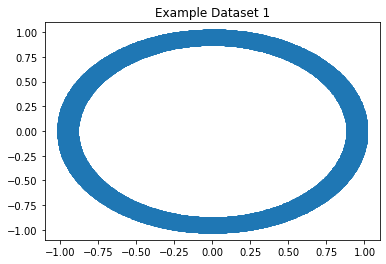

In [1]:
# Example dataset 1: Points on a disk-segment, where the correlation between x and y is zero,
# but the mutual information is not (at least in cartesian coordinates)

# Show the matplotlib plots within the jupyter notebook
%matplotlib inline

# Matplotlib for plotting and numpy for matrix manipulations and random numbers
import numpy as np
import matplotlib.pyplot as plt

# Number of samples (e.g. time points) in our synthetic dataset
n_samples = 100000

# Dimensions of x and y, in theory, they could be quite large. In practice, the sampling
# based approximation should work for tens of dimensions
dimX = 1
dimY = 1

# We are going to sample points (x,y) from a disk-segment of the radius range (0.9, 1.0) and
# all angles

r = np.random.rand(n_samples)*0.1 + 0.9
phi = np.random.rand(n_samples)*2*np.pi

# The important structure entering our mutual-information estimator is a single data matrix,
# where each row contains a single sample of the joint distribution p(x,y)

# Create empty data matrix
data = np.zeros((n_samples,2))

# First column of the data matrix will contain the x-values of the points
data[:,0] = np.cos(phi)*r
# Second column of the data matrix will contain the y-values of the points
data[:,1] = np.sin(phi)*r

# Plot the samples from the disk-segment
plt.figure()
plt.title('Example Dataset 1')
plt.scatter(data[:,0],data[:,1])
plt.show()


In [2]:
# Example dataset 2: Multivariate Gaussian with non-diagonal Covariance Matrix
# In this special case, the Mutual Information between subsets of the Gaussian's dimensions
# can be explicitly calculated, in terms of the determinants of the corresponding sub-matrices
# of the covariance matrix

# show matplotlin plots directly in the jupyter notebook
%matplotlib inline

# matplotlib for plotting, numpy for matrix manipulation and random numbers, 
# scipy for some little extra linear algebra
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy

# number of samples (e.g. time points) in our synthetic dataset
n_samples = 100000

# dimensionality of random variable X
dimX = 3
#dimensionality of random variable Y
dimY = 5
 
# We are going to draw samples from a multi-variate normal distribution,
# with dimensionality n = dimX + dim Y. 
# We use a zero mean and a random covariance matrix, whose off-diagonal elements
# will introduce dependencies between the first dimX dimensions,
# which we will use as random variable X, and the last dimY dimensions,
# which we will use as random variable Y.
# The nice thing is that in this case, there is a closed formula to directly
# calculate the mutual information between X and Y from the covariance matrix
# of this multi-variate normal distribution.

# dimensionality of multi-variate normal distribution
n = dimX + dimY

# random, but positive definite covariance matrix
L = np.random.randn(n,n)
cov = np.matmul(L, np.transpose(L))

# mean vector of zeros
mu = np.zeros(n)

# samples
data = np.random.multivariate_normal(mu,cov,n_samples)

# Exact expression for the mutual information as function of the determinant
# of the whole covariance matrix and the sub-matrices corresponding to random 
# variables X and Y
MI_exact = 0.5*np.log(np.linalg.det(cov[:dimX,:dimX])*np.linalg.det(cov[-dimY:,-dimY:])/np.linalg.det(cov))

print('Exact mutual information for this instance of example dataset 2: %f\n' % MI_exact)

#### A SPECIAL CASE of the above is the MI as function of 
#### the correlation between two one-dimensional Gaussian variables
# 
# dim1 = 1
# dim2 = 1
# 
# sigma = 0.1
# corr = 0.9
# 
# x = np.random.multivariate_normal([0,0],[[sigma, sigma*corr],[sigma*corr, sigma]],100000)
# 
# plt.scatter(x[:,0],x[:,1])
# plt.show()
# 
# MI_exact = -0.5*np.log(1-corr**2)
# 
# print('exact MI: %f' % MI_exact)
#

Exact Mutual Information for this instance of example dataset 2: 4.149142



Now you can run two sampling based estimators of the mutual information, by running the following cell.

In [8]:
# Use one of the cells above to create example data, then use this cell to run
# both versions of the sampling based approximation of mutual information
# (without RKHS regularisation, c.f. https://arxiv.org/abs/1906.01824;
# and with RKHS regularisation, c.f. https://arxiv.org/abs/2002.11187)

# We implemented two sampling based estimators, based on 
# https://arxiv.org/abs/1906.01824 ("Vanilla")
# and https://arxiv.org/abs/2002.11187 (using RKHS-regularisation)
from sampling_based_mutual_information import mutual_information_rkhs, mutual_information

# Our main input is a single data matrix, where each row is a sample from the joint
# distribution p(x,y), i.e. one time point of a simultaneous recording of x and y.
# So compare this shape with the dimensionalities dimX and dimY of the datasets created above.
print('Shape of input data matrix:')
print(data.shape)

# Parameters of the deep-learning based discriminator network and the training procedure

# Learning rate: If the loss-functions oscillate too much, reduce it. 
# Reducing the learning rate will require more training iterations.
learning_rate = 1e-3
# Number of neurons in each of the 2 hidden layers of the discriminator networks
n_hidden = 100
# Number of samples per mini-batch, which is used in the gradient-based training
# algorithm
batch_size = 1000
# Number of training iterations
n_iter = 5000
# Clip large gradients during training. This will increase stability, but also slow down
# training
clip_grad = False
# Norm, to which the gradient estimates will be clipped, if clip_grad = True
clip_norm = 0.1
# If log_mi_every > 0, every log_mi_every iteration the current estimate of the 
# mutual information will be evaluated and stored. Using this is highly recommended
# to examine the convergence of the training procedure.
log_mi_every = 100
# Number of samples from p(x,y), which will be used for the running estimate of
# the mutual information
log_mi_samples = 10000

# mutual_information_rkhs implements an additional penalty on the complexity of
# the discriminator, which aims to stabilise the training and the resulting
# mutual information estimates (for details please consult: https://arxiv.org/abs/2002.11187)
# Effectively, and additional penalty is added to the categorisation loss 
# (i.e. the binary cross entropy loss of a classifier, discriminating between
# samples from p(x,y) and samples from p(x)p(y).
# The additional regularisation cost is weighted by the following parameter.
penalty_rkhs = 1e-4

# Create the estimator using the RKHS-based complexity regularisation
RMI = mutual_information_rkhs(dimX, dimY, data, 
                              learning_rate = learning_rate, n_hidden = n_hidden, penalty = penalty_rkhs, 
                              clip_grad = clip_grad, clip_norm = clip_norm,
                              log_mi_every = log_mi_every, log_mi_samples = log_mi_samples)

# Start training
print('Training Regularized Discriminator')
RMI.train(n_iter = n_iter, batch_size = batch_size)

# Create the "Vanilla" estimator
MI = mutual_information(dimX, dimY, data, 
                        learning_rate = learning_rate, n_hidden = n_hidden, 
                        clip_grad = clip_grad, clip_norm = clip_norm,
                        log_mi_every = log_mi_every, log_mi_samples = log_mi_samples)

# Start training
print('Training Vanilla Discriminator')
MI.train(n_iter = n_iter, batch_size = batch_size)

# Calculate the mutual information estimates, using the learned discriminator networks
print('Regularized Approximation: %f\n' % RMI.approximate())
print('Vanilla Approximation: %f\n' % MI.approximate())

Shape of input data matrix:
(100000, 8)
Training Regularized Discriminator



Training Vanilla Discriminator



Regularized Approximation: 5.073546

Vanilla Approximation: 4.262749



It is really important to always plot the learning curves of the discriminators. This allows you to have a look at the evolution of the loss function and the learned mutual information estimates during training, which in turn allows you to spot failures of the discriminator to converge.

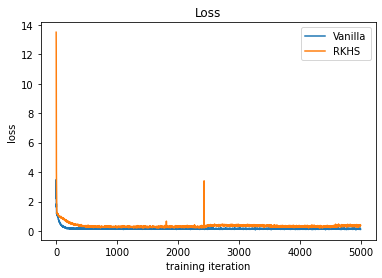

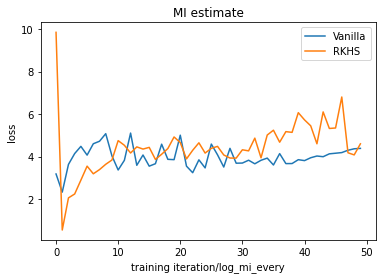

In [9]:
# Plot the curves of the training losses.
# THIS IS AN IMPORTANT STEP TO DIAGNOSE CONVERGENCE, WHICH ALWAYS SHOULD BE DONE,
# WHENEVER YOU ARE USING DEEP LEARNING OR SAMPLING BASED APPROXIMATIONS
# Remember: Here you're using *both*.

plt.figure()
plt.plot(MI.losses)
plt.plot(RMI.losses)
plt.title('Loss')
plt.legend(['Vanilla','RKHS'])
plt.xlabel('training iteration')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(MI.approximations)
plt.plot(RMI.approximations)
plt.title('MI estimate')
plt.legend(['Vanilla','RKHS'])
plt.xlabel('training iteration/log_mi_every')
plt.ylabel('loss')
plt.show()

# Conditional Mutual Information Estimation Example

Here we show how to use a sampling-based approximation of the conditional mutual information, as proposed by Mukherjee et al. (2019; https://arxiv.org/abs/1906.01824).

The basic idea is the following: We can calculate the conditional mutual information of $x$ and $y$, given a third random variable $z$, $CMI(X,Y|Z)$, via the differences:

$$CMI(X,Y|Z) = MI(X,YZ) - MI(X,Z) = MI(Y,XZ) - MI(Y,Z)$$

Due to the symmetry of the conditional mutual information in $x$ and $y$, and the symmetry of the mutual information in the two arguments, both differences should in principle give the same answer and work equally well.

*In practice*, however, the discriminator networks, which are learned to approximate the individual mutual informations, might differ substantially in their convergence properties. Thus, I'd recommed using the "both_dir = True" option in the constructor of the conditional_mutual_information class. This way, all four mutual informations of the equation above will be estimated and both ways of partitioning the conditional mutual information into a difference of two mutual informations will be used. They *should* give the same answer, if all four networks - $MI(X,YZ)$, $MI(X,Z)$, $MI(Y,XZ)$, and $MI(Y,Z)$ - converged.

First create samples from an example distribution p(x,y,z), following Mukherjee et al. (2019; https://arxiv.org/abs/1906.01824)

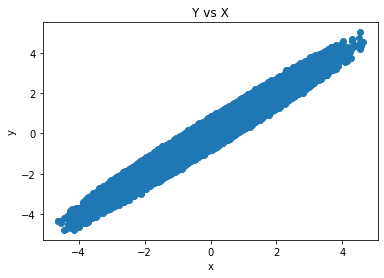

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Demo model, also used in Mukherjee et al. (2019; https://arxiv.org/abs/1906.01824)
# The ground truth value of 2.3 was calculated using numerical integration by the authors
# of this paper (c.f. Fig. 2a).

# We want to compute MI(X,Y|Z) later.

n_samples = 1000000

dimZ = 20

# X is drawn from a one-dimensional standard normal distribution
x = np.random.randn(n_samples).reshape(n_samples,1)

# Z is drawn from a dimZ-dimensional uniform distribution on [-0.5,0.5]^dimZ
z = np.random.rand(n_samples, dimZ) - 0.5

sigma_epsilon = 0.1

# Epsilon is drawn from a one-dimensional normal distribution with mean z_1 and standard
# deviation 0.1
epsilon = (np.random.randn(n_samples)*sigma_epsilon + z[:,0]).reshape(n_samples,1)

# Y is the sum of x and epsilon
y = x + epsilon

plt.figure()
plt.title('Y vs X')
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now train a sampling based extimator of the conditional mutual information CMI(X,Y|Z), whose true value was estimated by Mukherjee et al. (2019; https://arxiv.org/abs/1906.01824) to about 2.3.

In [ ]:
from sampling_based_mutual_information import conditional_mutual_information

data = np.concatenate((x,y,z),axis = 1)

# Learning rate: If the loss-functions oscillate too much, reduce it.  
# Reducing the learning rate will require more training iterations.
learning_rate = 1e-3
# Number of neurons in each of the 2 hidden layers of the discriminator networks
n_hidden = 100
# Number of samples per mini-batch, which is used in the gradient-based training
# algorithm
batch_size = 1000
# Number of training iterations
n_iter = 5000
# Clip large gradients during training. This will increase stability, but also slow down
# training
clip_grad = False
# Norm, to which the gradient estimates will be clipped, if clip_grad = True
clip_norm = 0.1
# If log_mi_every > 0, every log_mi_every iteration the current estimate of the 
# mutual information will be evaluated and stored. Using this is highly recommended
# to examine the convergence of the training procedure.
log_mi_every = 100
# Number of samples from p(x,y), which will be used for the running estimate of
# the mutual information
log_mi_samples = 10000

# mutual_information_rkhs implements an additional penalty on the complexity of
# the discriminator, which aims to stabilise the training and the resulting
# mutual information estimates (for details please consult: https://arxiv.org/abs/2002.11187)
# Effectively, and additional penalty is added to the categorisation loss 
# (i.e. the binary cross entropy loss of a classifier, discriminating between
# samples from p(x,y) and samples from p(x)p(y).
# The additional regularisation cost is weighted by the following parameter.
penalty_rkhs = 1e-3

CMI = conditional_mutual_information(1, 1, dimZ, data, 
                                     learning_rate = learning_rate, n_hidden = n_hidden, 
                                     clip_grad = clip_grad, clip_norm = clip_norm, 
                                     use_rkhs = use_rkhs, rkhs_penalty = rkhs_penalty, 
                                     both_dir = both_dir,
                                     log_mi_every = log_mi_every, log_mi_samples = log_mi_samples)

CMI.train(n_iter = n_iter, batch_size = batch_size)

print('Sampling based approximation or approximations (both_dir = True: both equivalent decompositions of conditional mutual information as difference of mutual informations):')
print(CMI.approximate())



Plotting the training curves is absolutely essential, to check if the discriminator training really converged. Just by examining the final conditional mutual information estimates, it is not possible to spot convergence failure.

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(CMI.MI_X_YZ.losses)
plt.plot(CMI.MI_X_Z.losses)
plt.title('forward loss')
plt.legend(['MI(X,YZ)','MI(X,Z)'])
plt.xlabel('training iteration')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(CMI.MI_Y_XZ.losses)
plt.plot(CMI.MI_Y_Z.losses)
plt.title('backward loss')
plt.legend(['MI(Y,XZ)','MI(Y,Z)'])
plt.xlabel('training iteration')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(CMI.MI_X_YZ.approximations)
plt.plot(CMI.MI_X_Z.approximations)
plt.plot(np.asarray(CMI.MI_X_YZ.approximations) - np.asarray(CMI.MI_X_Z.approximations))
plt.title('forward')
plt.legend(['MI(X,YZ)','MI(X,Z)','CMI(X,Y|Z)'])
plt.xlabel('training iteration/log_mi_every')
plt.ylabel('loss')
plt.show()

plt.figure()
plt.plot(CMI.MI_Y_XZ.approximations)
plt.plot(CMI.MI_Y_Z.approximations)
plt.plot(np.asarray(CMI.MI_Y_XZ.approximations) - np.asarray(CMI.MI_Y_Z.approximations))
plt.title('backward')
plt.legend(['MI(Y,XZ)','MI(Y,Z)','CMI(X,Y|Z)'])
plt.xlabel('training iteration/log_mi_every')
plt.ylabel('loss')
plt.show()

# Some intuition and connections w.r.t. the Binary Cross-Entropy loss

## Binary cross entropy as log-likelihood of a Bernoulli model

Let's say we have a dataset consisting of high-dimensional datapoints $x_i \in \mathbb{R}^d$, which were drawn from two different distributions $p(x|y)$, where $y\in \{ 0,1 \}$.

Let us describe the true, underlying data distribution $p(x,y) = p(y|x)p(x)$ in terms of the a priori probabiliy of a sample having a specific value of $p(x)$ and the conditional probability on the class labels $p(y|x)$.

We want to learn a conditional Bernoulli distribution, using a deep neural network $D$, to give us an estimate of the conditional probability $p_\mathrm{est}(y = 1|x_i) = \hat{y}_i = \sigma(D(x_i))$ for a given datapoint $x_i$, where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid function. 

Assuming i.i.d samples from the data distribution, we can write down the likelihood of a sample of datapoints $(x_i, y_i), i=1, ..., n$ under this model:

$$L(\{(x_i, y_i)\}) = \prod_{i=1}^n p(y_i | x_i)$$

Where the likelihood of a single datapoint $L(x_i, y_i)$ is given by $L(x_i, y_i) = p_\mathrm{est}(y=y_i|x_i) = \begin{cases}
\sigma(D(x)), \text{if } y = 1\\
1 - \sigma(D(x)), \text{if } y = 0
\end{cases}$

Thus, we see that the binary cross entropy loss just corresponds to the log-likelihood of the data under the model $p_\mathrm{est}(y|x)$:
$$ BCE(\{x_i, y_i\} = \sum_{i=1}^n \log L(x_i, y_i) = \log L(\{(x_i, y_i)\})$$ 

## Binary cross entropy as Kullback-Leibler divergence between true posterior on class labels and modeled Bernoulli distribution

Just to give a short intuition, w.r.t. the binary cross entropy loss above: You could also see it as the average KL-divergence of the learned and the true categorical distribution of labels $y$, given a data point $x$. Where 
Continueing with the definitions above, we can interpret the true class labels $y(x)$ as defining the true posterior distribution $p(y|x)$, via:

$$y(x) = p(y=1|x) = \begin{cases}
                    1, \text{if } x ~ p(x)\\
                    0, \text{if } x ~ q(x)
                    \end{cases}$$
                    
Remember, that we want to use our deep neural network to model a conditional Bernouilli distribution on the class labels, via $p_\mathrm{est}(y=1|x) = \hat{y} = \sigma(D(x))$.
                    
Thus, we can write 

$$
\begin{align}
D_\mathrm{KL}(p(x,y)||p_\mathrm{est}(x,y)) & = & \int_x \left(  p(y=1|x)p(x)\log\left(\frac{p(y=1|x)p(x)}{p_\mathrm{est}(y=1|x)p(x)}\right) + p(y=0|x)p(x)\log\left(\frac{p(y=0|x)p(x)}{p_\mathrm{est}(y=0|x)p(x)}\right) \right) \mathrm{d}x\\
& = & \int_x \left(  p(y=1|x)\log\left(\frac{p(y=1|x)}{p_\mathrm{est}(y=1|x)}\right) + p(y=0|x)\log\left(\frac{p(y=0|x)}{p_\mathrm{est}(y=0|x)}\right) \right)p(x) \mathrm{d}x\\
& \approx & \sum_{x_i}\left[ p(y=1|x_i)\log\left(\frac{p(y=1|x_i)}{p_\mathrm{est}(y=1|x_i)}\right) + p(y=0|x_i)\log\left(\frac{p(y=0|x_i)}{p_\mathrm{est}(y=0|x_i)}\right) \right]\\
& = & - \sum_{x_i}\left[ y_i \log\left(p_\mathrm{est}(y=1|x_i)\right) + (1-y_i)\log\left(p_\mathrm{est}(y=0|x_i)\right) + \underbrace{H(p(y|x_i))}_{=0}\right]\\
& = & - \sum_{x_i}\left[ y_i \log\left(\sigma(D(x_i))\right) + (1-y_i)\log\left(1-\sigma(D(x_i)\right)\right]\\
& = & BCE(\{x_i, y_i\}
\end{align}
$$
where $y_i = y(x_i) = p(y_i = 1|x_i)$ are the true labels, i.e. $p(y_i = 0 | x_i) = 1 - y_i$, and the model gives $p_\mathrm{est}(y=1|x_i) = \hat{y}_i = \sigma(D(x_i))$ and $p_\mathrm{est}(y=0|x_i) = 1 - \hat{y}_i = 1 - \sigma(D(x_i))$ .


Thus, assuming i.i.d samples from the data distribution, we can also write 
$$ BCE(\{x_i, y_i\} = \sum_{i=1}^n \log L(x_i, y_i)$$
I.e. the binary cross entropy can also be seen as the log-likelihood of the data $\{x_i, y_i\}$ under the learned model distribution $p_\mathrm{est}(y|x)$.